# Bifrost Gradient Booster
A generic autonomous model builder for regression and time series forecasting problems using gradient boosting.

## Install Dependencies

In [115]:
!pip install xgboost pandas numpy sklearn graphviz

## Import Dependencies

In [116]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Implementation

In [129]:
class BifrostGradientBooster:
    default_parameters = {
        'learning_rate': 0.1,
        'max_depth': 3,
        'colsample_bytree': 1,
        'subsample': 1,
        'min_child_weight': 1,
        'gamma': 1,
        'random_state': 1502,
        'eval_metric': "rmse",
        'objective': "reg:squarederror"
    }
    
    def __init__(self, 
                 data: pd.DataFrame):
        self.data = data
        self.model = None

    def __get_training_test_dfs__(self, training_split: float):
        training_record_count = int(len(self.data) * training_split)
        
        return self.data[:training_record_count], self.data[training_record_count:]

    def __get_x_y_dfs__(self, df: pd.DataFrame, column_name_to_predict: str) -> pd.DataFrame:
        x = df.drop(columns=[column_name_to_predict])
        y = df.loc[:, [column_name_to_predict]]
        
        return x, y

    def __get_df_matrix__(self, df: pd.DataFrame, column_name_to_predict: str, name: str) -> xgb.DMatrix:
        x, y = self.__get_x_y_dfs__(df, column_name_to_predict=column_name_to_predict)
        matrix = xgb.DMatrix(data = x, label = y)
        
        print(f'[{name}] Matrix X: {x.shape}, Matrix Y: {y.shape}')
        
        return matrix

    def __calculate_mape_score__(self, y_true: pd.Series, y_pred: pd.Series):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def __print_model_assessment__(self, test_column_data: pd.Series, predictions: pd.Series):
        print(f'Mean Absolute Error: {mean_absolute_error(test_column_data, predictions)}')
        print(f'Mean Squared Error: {np.sqrt(mean_squared_error(test_column_data, predictions))}')
        print(f'MAPE: {self.__calculate_mape_score__(test_column_data, predictions)}')

    def drop_columns_with_no_unique_values(self):
        columns_to_drop = [ c for c in self.data.columns if len(self.data[c].unique()) <= 1 ]
        print(f'Dropping {len(columns_to_drop)} columns due to only containing 1 or less unique values. -> {columns_to_drop}')
        self.data.drop(columns=columns_to_drop, inplace=True)
        
        return self

    def replace_whitespace(self,
                           substitute: str = '_',
                           from_column_names: bool=True, 
                           from_values: bool=True):
        if from_column_names:
            self.data.columns = self.data.columns.str.replace(' ', substitute)
        
        if from_values:
            self.data.replace(' ', substitute, regex=True, inplace=True)
            
        print(f'Whitespace replaced with "{substitute}".')
        
        return self

    def replace_missing_values(self, value: int = 0):
        self.data.fillna(value)
        
        print(f'Replaced all missing values with {value}.')
        
        return self

    def featurize_time_from_column(self, column_name: str, column_prefix: str='t_'):
        parsed_date_temporary_column = pd.to_datetime(self.data[column_name])
        self.data.drop(columns=[column_name], inplace=True)
            
        self.data[f'{column_prefix}year'] = parsed_date_temporary_column.dt.year
        self.data[f'{column_prefix}month'] = parsed_date_temporary_column.dt.month
        self.data[f'{column_prefix}day'] = parsed_date_temporary_column.dt.day
        self.data[f'{column_prefix}hour'] = parsed_date_temporary_column.dt.hour
        self.data[f'{column_prefix}minute'] = parsed_date_temporary_column.dt.minute
        self.data[f'{column_prefix}day_of_year'] = parsed_date_temporary_column.dt.dayofyear
        self.data[f'{column_prefix}day_of_week'] = parsed_date_temporary_column.dt.dayofweek
        self.data[f'{column_prefix}quarter'] = parsed_date_temporary_column.dt.quarter
            
        print(f'Extracted time series features from column "{column_name}" and dropped the original column.')
        
        return self

    def onehot_encode_categorical_columns(self, column_names: list):
        if len(column_names) > 0:
            self.data = pd.get_dummies(self.data, columns=column_names)
            print(f'One-Hot encoded {len(column_names)} columns. -> {column_names}')
        
        return self

    def fit(self, 
            column_name_to_predict: str,
            enable_hyperparameter_optimization: bool,
            training_split: float=0.8):
        training_df, testing_df = self.__get_training_test_dfs__(training_split=training_split)
        training_matrix = self.__get_df_matrix__(training_df, column_name_to_predict=column_name_to_predict, name='Training')
        testing_matrix = self.__get_df_matrix__(testing_df, column_name_to_predict=column_name_to_predict, name='Testing')
        
        if enable_hyperparameter_optimization:
            raise NotImplementedError()
        
        self.model = xgb.train(
            params = self.default_parameters,
            dtrain = training_matrix,
            num_boost_round = 1000,
            evals = [(testing_matrix, column_name_to_predict)],
            verbose_eval = 200)

        return self
    
    def evaluate(self,
                 column_name_to_predict: str,
                 training_split: float=0.8):
        training_df, testing_df = self.__get_training_test_dfs__(training_split=training_split)
        testing_matrix = self.__get_df_matrix__(testing_df, column_name_to_predict=column_name_to_predict, name='Testing')
        
        # Predict
        predictions = pd.Series(self.model.predict(testing_matrix))
        predictions.index = testing_df.index
        
        training_df[column_name_to_predict].rename('Training Data').plot(figsize=(9,6), legend=True)
        testing_df[column_name_to_predict].rename('Test Data').plot(legend=True)
        predictions.rename('Predictions').plot(legend=True)
        
        # Evaluate
        self.__print_model_assessment__(testing_df[column_name_to_predict], predictions)
        
        return self
    
    def visualize(self, verbose: bool=False):
        node_params = {
            'shape': 'box',
            'style': 'fixed, rounded',
            'fillcolor': '#e48038'
        }
        leaf_params = {
            'shape': 'box',
            'style': 'filled',
            'fillcolor': '#e48038'
        }
        
        if verbose:
            for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
                print(f'{importance_type}: {self.model.get_score(importance_type=importance_type)}')
        
        return xgb.to_graphviz(self.model, num_trees=0, size='10,10', condition_node_params=node_params, leaf_node_params=leaf_params)

Replaced all missing values with 0.
Extracted time series features from column "dteday" and dropped the original column.
Dropping 2 columns due to only containing 1 or less unique values. -> ['t_hour', 't_minute']
Whitespace replaced with "_".
[Training] Matrix X: (584, 20), Matrix Y: (584, 1)
[Testing] Matrix X: (147, 20), Matrix Y: (147, 1)
[0]	cnt-rmse:5628.72432
[200]	cnt-rmse:252.92705
[400]	cnt-rmse:240.29877
[600]	cnt-rmse:238.25150
[800]	cnt-rmse:236.27650
[999]	cnt-rmse:235.35054
[Testing] Matrix X: (147, 20), Matrix Y: (147, 1)
Mean Absolute Error: 171.9642257171423
Mean Squared Error: 235.35053786995903
MAPE: 15.85447268537564


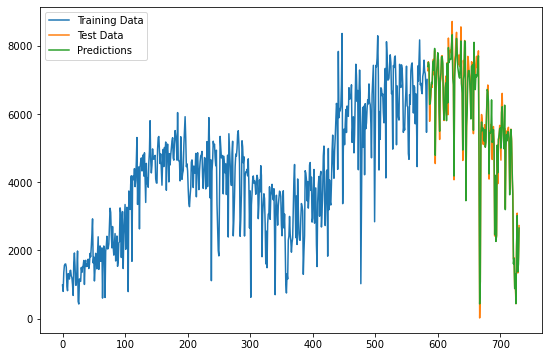

In [130]:
regressor = (BifrostGradientBooster(data=pd.read_csv('./../../data/daily_bike_sharing.csv'))
    .replace_missing_values()
    .featurize_time_from_column(column_name='dteday')
    .drop_columns_with_no_unique_values()
    .replace_whitespace()
    .fit(column_name_to_predict='cnt', enable_hyperparameter_optimization=False)
    .evaluate(column_name_to_predict='cnt')
)

weight: {'instant': 809.0, 'season': 24.0, 'mnth': 53.0, 'holiday': 35.0, 'weekday': 223.0, 'workingday': 26.0, 'weathersit': 50.0, 'temp': 448.0, 'atemp': 327.0, 'hum': 618.0, 'windspeed': 682.0, 'casual': 1175.0, 'registered': 1230.0, 't_day': 273.0, 't_day_of_year': 355.0, 't_day_of_week': 74.0}
gain: {'instant': 982491.875, 'season': 1321.8572998046875, 'mnth': 4283.05029296875, 'holiday': 894.8955078125, 'weekday': 4368.02587890625, 'workingday': 2813.1376953125, 'weathersit': 2563.64599609375, 'temp': 9288.5927734375, 'atemp': 14583.7275390625, 'hum': 2331.665771484375, 'windspeed': 3571.456298828125, 'casual': 828167.5, 'registered': 6043357.0, 't_day': 1932.3812255859375, 't_day_of_year': 2953.716796875, 't_day_of_week': 4368.44970703125}
cover: {'instant': 190.2385711669922, 'season': 65.29166412353516, 'mnth': 48.58490753173828, 'holiday': 139.54286193847656, 'weekday': 72.32286834716797, 'workingday': 20.269229888916016, 'weathersit': 22.700000762939453, 'temp': 192.69642639

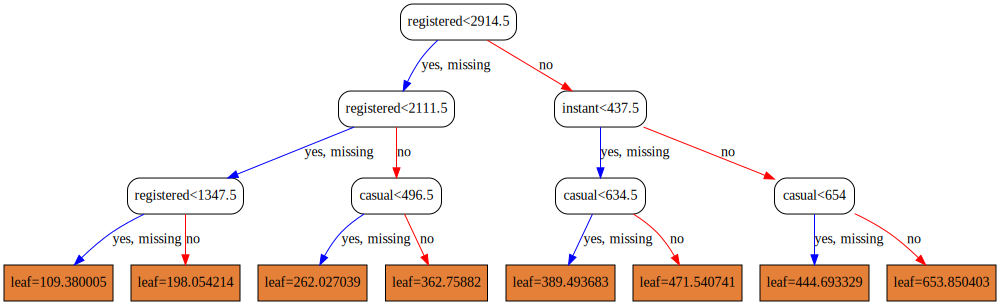

In [131]:
regressor.visualize(verbose=True)